In [149]:
# Import the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler


In [ ]:
#Functions
def slice_by_country(county_name, country_column_name, data_frame):
    sliced_df = data_frame[data_frame[country_column_name] == country_name]
    return sliced_df

def map_countries_to_numeric(countries,numericVals,numeric_column_name,df):
    country_mapping = []
     # Converting binary Nominal Variable Country to numeric
    for i in range(len(countries)):
        country_mapping.append(numericVals[i])
    df.reset_index()
    df[numeric_column_name] = country_mapping
    return df

In [151]:
population_df = pd.read_csv("population_by_year_2014_2024.csv")
meat_df = pd.read_csv("Consumption of meat per capita.csv")

In [152]:
population_df = population_df.drop(columns= ['2022', '2023', '2024'])
population_df = population_df.sample(n=11, random_state=65)
population_df.head(11)

,Country,2014,2015,2016,2017,2018,2019,2020,2021
66,Guatemala,58793503,60432172,62116514,63847801,65627342,67456482,69336603,71269125
31,Canada,55881368,57087709,58320092,59579080,60865246,62179177,63521473,64892746
12,Bahrain,139249233,141789315,144375731,147009327,149690963,152421515,155201877,158032955
87,Kiribati,112049993,114062213,116110570,118195712,120318299,122479004,124678511,126917518
91,Latvia,4595583,4699269,4805294,4913711,5024575,5137940,5253863,5372401
159,South Africa,149688768,150589627,151495909,152407645,153324867,154247610,155175906,156109789
149,Saudi Arabia,66703416,68267439,69868134,71506362,73183002,74898955,76655142,78452508
148,Sao Tome and Principe,80755119,83086651,85485498,87953604,90492968,93105647,95793759,98559482
162,Spain,142001830,144395177,146828864,149303568,151819982,154378809,156980762,159626570
114,Morocco,3381068,3400551,3420147,3439855,3459677,3479614,3499665,3519832


In [153]:
meat_df = meat_df[meat_df['Year'] >= 2014]
meat_df.head()

,Entity,Year,Poultry,Beef,Sheep and goat,Pork,Other meats,Fish and seafood
53,Afghanistan,2014,2.11,4.989999,5.059999,0.03,0.43,0.19
54,Afghanistan,2015,1.96,3.810000,4.770000,0.02,0.36,0.21
55,Afghanistan,2016,2.00,3.280000,4.800000,0.01,0.36,0.23
56,Afghanistan,2017,1.79,2.920000,4.450000,0.02,0.33,0.43
57,Afghanistan,2018,1.46,2.670000,4.319999,0.03,0.32,0.42


In [155]:
population_long = pd.melt(population_df, id_vars=["Country"],
                          var_name="Year", value_name="Population")
population_long.rename(columns={"Country": "Entity"}, inplace=True)
population_long["Year"] = pd.to_numeric(population_long["Year"])
population_long.head()

,Entity,Year,Population
0,Guatemala,2014,58793503
1,Canada,2014,55881368
2,Bahrain,2014,139249233
3,Kiribati,2014,112049993
4,Latvia,2014,4595583


In [156]:
population_long["Year"] = pd.to_numeric(population_long["Year"], errors='coerce')
meat_df["Year"] = pd.to_numeric(meat_df["Year"], errors='coerce')
combined_df = pd.merge(population_long, meat_df, on=["Entity", "Year"], how="inner")
combined_df.head(10)

,Entity,Year,Population,Poultry,Beef,Sheep and goat,Pork,Other meats,Fish and seafood
0,Guatemala,2014,58793503,17.929996,11.579997,0.190000,4.839999,0.200000,3.039999
1,Canada,2014,55881368,37.389990,31.109995,0.980000,22.969995,0.020000,23.189997
2,Kiribati,2014,112049993,15.137104,7.378589,0.159969,7.998470,0.039992,74.965660
3,Latvia,2014,4595583,20.730000,4.720000,0.360000,35.330000,0.280000,23.000000
4,South Africa,2014,149688768,37.119995,18.399998,3.310000,4.469999,0.850000,7.119999
5,Saudi Arabia,2014,66703416,38.869987,6.429998,5.929998,NaN,1.430000,11.919996
6,Sao Tome and Principe,2014,80755119,9.489471,1.299928,0.039998,5.009721,0.029998,29.328367
7,Spain,2014,142001830,29.250002,11.260001,2.390000,51.150005,1.740000,44.330006
8,Morocco,2014,3381068,20.409996,6.919999,4.919999,0.020000,1.840000,17.009996
9,Kyrgyzstan,2014,79068913,3.679996,15.649983,8.599992,5.849994,1.509998,3.009997


In [158]:
combined_df = map_countries_to_numeric(['Guatemala', 'Canada'],[1,2],"country_map",combined_df)

ValueError: Length of values (2) does not match length of index (83)

In [135]:
features = ['Year','Entity', 'Population' , 'Poultry', 'Beef', 'Sheep and goat', 'Other meats', 'Fish and seafood']
target = 'Pork'

# Remove rows with missing values
df_clean = combined_df.dropna(subset=features + [target])
X = df_clean[features]
y = df_clean[target]
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [136]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initialize and train Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
# Train model
gb_model.fit(X_train_scaled, y_train)
# Make predictions
y_pred = gb_model.predict(X_test_scaled)



ValueError: could not convert string to float: 'South Africa'

In [80]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

Model Performance Metrics:
MSE: 476138015257561.3125
RMSE: 21820586.9595
MAE: 16253375.9058
R2 Score: 0.7660


In [81]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [82]:
# Print best parameters and score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Score:", np.sqrt(-grid_search.best_score_))


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 300}
Best Score: 20300286.453538325


In [83]:
# Train final model with best parameters
best_gb = grid_search.best_estimator_
best_pred = best_gb.predict(X_test_scaled)

In [84]:
# Calculate final metrics
final_mse = mean_squared_error(y_test, best_pred)
final_r2 = r2_score(y_test, best_pred)
print("\nFinal Model Performance:")
print(f"MSE: {final_mse:.4f}")
print(f"R2 Score: {final_r2:.4f}")


Final Model Performance:
MSE: 318256767763306.0000
R2 Score: 0.8436


In [85]:
# Feature importance plot
plt.figure(figsize=(10, 6))
importance_df = pd.DataFrame({
    'feature': features,
    'importance': best_gb.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=True)
importance_df

,feature,importance
0,Year,0.006017
1,Pork,0.136565
5,Other meats,0.141401
6,Fish and seafood,0.167412
4,Sheep and goat,0.170441
3,Beef,0.173551
2,Poultry,0.204613


<Figure size 1000x600 with 0 Axes>

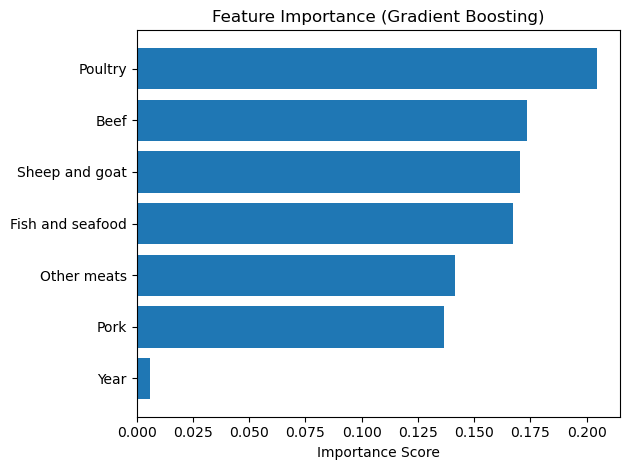

In [86]:
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

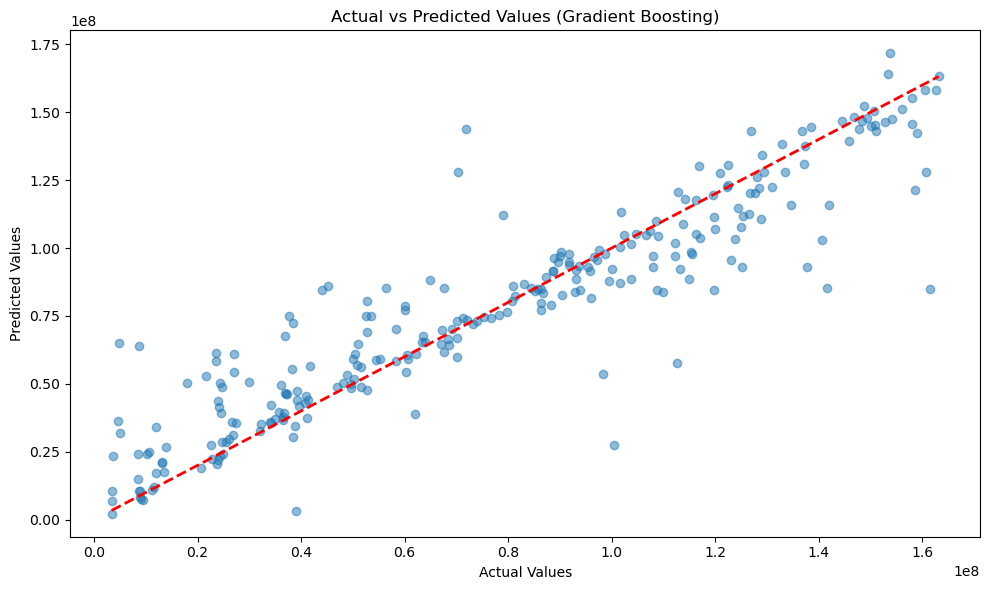

In [87]:
# Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Gradient Boosting)')
plt.tight_layout()
plt.show()

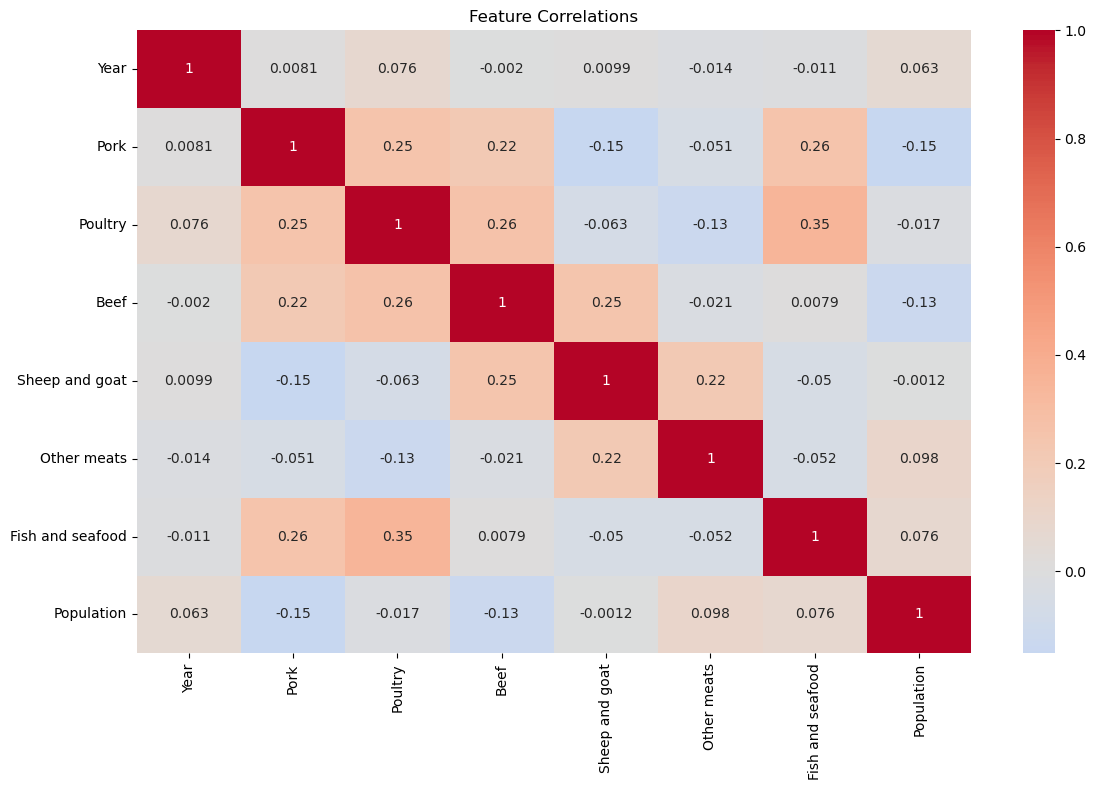

In [88]:
# Additional analysis: Feature correlations
plt.figure(figsize=(12, 8))
correlation_matrix = df_clean[features + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

In [ ]:
future_years = np.arange(2021, 2032)
future_features = pd.DataFrame({
    'Pork': np.random.rand(len(future_years)),
    'Poultry': np.random.rand(len(future_years)),
    'Beef': np.random.rand(len(future_years)),
    'Sheep and goat': np.random.rand(len(future_years)),
    'Other meats': np.random.rand(len(future_years)),
    'Fish and seafood': np.random.rand(len(future_years))
})

future_predictions = best_gb.predict(future_features)
plt.figure(figsize=(10, 6))
plt.plot(future_years, future_predictions, marker='o', linestyle='-', color='b', label='Predicted Values')
plt.title('Predictions for 2021–2031')
plt.xlabel('Year')
plt.ylabel('Predicted Value')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()